# Problem Set - AS–AD Model (Closed and Open Economy)


**Table of contents**<a id='toc0_'></a>    
- 1. [Baseline static equilibrium (closed economy)](#toc1_)    
- 2. [Slope diagnostics: analytical vs numerical](#toc2_)    
- 3. [Write your own grid solver](#toc3_)    
- 4. [Comparative statics: demand vs supply shocks (closed)](#toc4_)    
- 5. [Simulation & reproducibility with seeds](#toc5_)    
  - 5.1. [Same seed → identical shocks and paths](#toc5_1_)    
  - 5.2. [Different seeds → different shocks](#toc5_2_)    
  - 5.3. [Impulse vs stochastic runs (same seed, different mode)](#toc5_3_)    
- 6. [Tiny policy search over $(a_1,a_2)$](#toc6_)    
  - 6.1. [Build AR(1) shocks for demand and supply](#toc6_1_)    
  - 6.2. [Simulate with a given rule and compute quadratic loss](#toc6_2_)    
  - 6.3. [Tiny grid search over $(a_1, a_2)$ and heatmap](#toc6_3_)    
- 7. [Open economy: fixed vs flexible (static)](#toc7_)    
- 8. [Optional: Peg vs float under persistent cost pressure](#toc8_)    
  - 8.1. [Set up a supply dominated stochastic scenario](#toc8_1_)    
  - 8.2. [Compare volatility of output and inflation](#toc8_2_)    
  - 8.3. [Plot and interpret the stochastic paths](#toc8_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Setup**

Keyboard shortcuts for Jupyter Notebooks: 
https://discourse.jupyter.org/t/most-useful-keyboard-shortcuts-for-notebook-lab/18113

In [2]:
# --- SETUP (run once) ---
import numpy as np
import matplotlib.pyplot as plt
import runpy

# Optional: cleaner plots
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Unified parameter dict used for BOTH closed and open economy code
par = dict(
    # Steady state
    ybar       = 1.0,    # potential output \bar y
    pi_star    = 0.02,   # domestic inflation target \pi^*
    pi_foreign = 0.02,   # foreign inflation (open economy anchor)

    # IS curve + Taylor rule (works for closed & flexible-rate open AD)
    b   = 0.6,    # IS sensitivity to real rate
    a1  = 1.5,    # policy response to inflation gap (>1 for Taylor principle)
    a2  = 0.10,   # policy response to output gap (>=0)

    # Phillips curve (SRAS)
    gamma = 0.4,  # slope of SRAS

    # Expectations persistence (closed-economy dynamics)
    phi = 0.7,    # persistence of expected inflation

    # Openness / exchange-rate channel (open economy)
    alpha_er = 0.50,  # extra AD stabilization under flexible ER
    beta1    = 0.50,  # AD sensitivity to real exchange rate under a peg

    # Shock dynamics for simulations (both versions can use these)
    delta   = 0.80,   # AR(1) persistence of demand shocks
    omega   = 0.15,   # AR(1) persistence of supply shocks
    sigma_x = 0.01,   # std dev of demand shock innovations
    sigma_c = 0.005   # std dev of supply shock innovations
)




## 1. <a id='toc1_'></a>[Baseline static equilibrium (closed economy)](#toc0_)

**Goal.** Compute and plot the baseline SRAS–AD with no shocks, and adaptive expectations $\pi_e=\pi^*$. Report $(y^*,\pi^*)$.

**Steps.**
1. Call `solve_grid(pi_e=par_closed["pi_star"], v=0, s=0, p=par)`.
2. Plot AD, SRAS, LRAS; mark the equilibrium using `plot_grid(pi_e=0.02, v=0, s=0, p=par)`.

**Hints.**
- Use `pad≈0.6`, `n≈400`.


In [3]:
# Ensures automatic reloading of module
%load_ext autoreload 
%autoreload 2

# Import function from module
from functions import * # imports all functions from functions.py

0.9984962406015039 0.022355889724310588


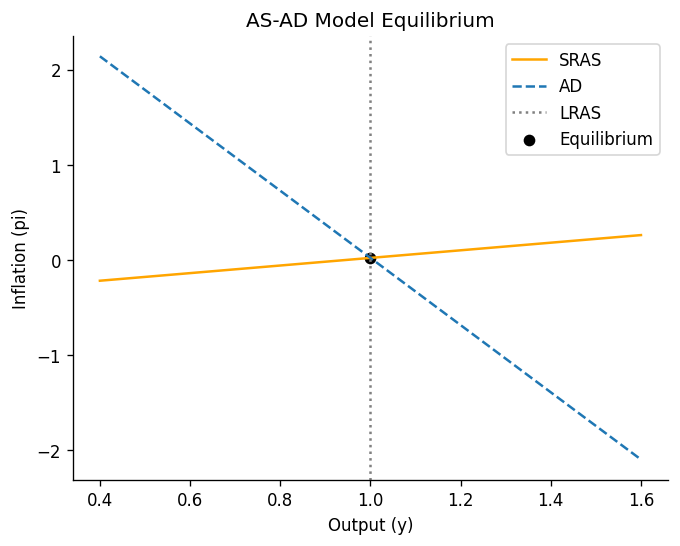

In [4]:
# Use function to solve for equilibrium in closed economy
y_star, pi_star, y, pi_ad, pi_sras = solve_grid(pi_e=par["pi_star"], v=0.0, s=0.0, p=par, pad=0.6, n=400) # Why call p=par? Because the function expects a parameter dictionary
print(y_star, pi_star)


# Build plot with SRAS (solid), AD (dashed), LRAS (vertical at ybar), and the equilibrium marker
import matplotlib.pyplot as plt

plt.plot(y, pi_sras, label="SRAS", linestyle='-', color="orange")
plt.plot(y, pi_ad, label="AD", linestyle='--')
plt.axvline(x=par["ybar"], color='gray', label="LRAS", linestyle=':')
plt.scatter(y_star, pi_star, color='black', label="Equilibrium")
plt.xlabel("Output (y)")
plt.ylabel("Inflation (pi)")
plt.title("AS-AD Model Equilibrium")
plt.legend()
plt.show()

Baseline equilibrium: y*=0.9985, pi*=0.0224
Equilibrium: y*=0.9985, pi*=0.0224


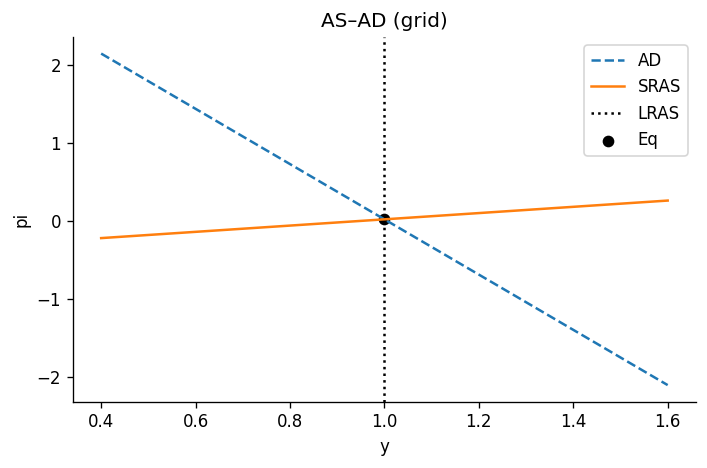

In [5]:
_ = runpy.run_module("A1", run_name="__main__")  # RUNS A1.py

## 2. <a id='toc2_'></a>[Slope diagnostics: analytical vs numerical](#toc0_)

**Goal.** Verify that the **numerical** slopes at $y=\bar y$ match the **analytical** slopes.

**Setup.**  
- AD: $\pi(y)=\pi^* - \frac{(y-\bar y)-z_t}{\alpha} \Rightarrow \frac{d\pi}{dy}=-\frac{1}{\alpha}$, with $\alpha=\frac{b(a_1-1)}{1+ba_2}$.  
- SRAS: $\pi(y)=\pi_e + \gamma(y-\bar y)+s \Rightarrow \frac{d\pi}{dy}=\gamma$.

**Steps.**  
1. Compute analytical slopes from `par`.  
2. Approximate numerical slopes by centered finite differences at $y=\bar y$.  
3. Assert closeness within $10^{-3}$.

**Hints.**  
- Use `from functions import ad_curve, sras_curve` and evaluate both curves at $y=\bar y \pm h$ for a small step size $h$ (for instance $h=10^{-5}$).  
- Use `np.isclose` with `atol=1e-3` to automatically check that analytical and numerical slopes are sufficiently close.


In [6]:
# I display the parameter dictionary as I for the life of me cannot remember the names of the parameters
par

{'ybar': 1.0,
 'pi_star': 0.02,
 'pi_foreign': 0.02,
 'b': 0.6,
 'a1': 1.5,
 'a2': 0.1,
 'gamma': 0.4,
 'phi': 0.7,
 'alpha_er': 0.5,
 'beta1': 0.5,
 'delta': 0.8,
 'omega': 0.15,
 'sigma_x': 0.01,
 'sigma_c': 0.005}

In [7]:
# STARTER: compute analytical and numerical slopes and compare

p = par              # Use p instead of par for brevity

# --- 1) Analytical slopes --------------------------------------
alpha_ad = p["b"]*(p["a1"]-1.0)/(1.0+p["b"]*p["a2"])           # compute the AD sensitivity parameter from p
slope_ad_analytical   = -1.0/alpha_ad # analytical slope of AD at y = ybar
slope_sras_analytical = p["gamma"] # analytical slope of SRAS at y = ybar

# --- 2) Numerical slopes (centered differences around y0) ------
h    = 1e-5
y0   = p["ybar"]
exp_inflation = p["pi_star"]
v = 0.0          # demand disturbance
s = 0.0          # supply disturbance

# AD curve: inflation = ad_curve(y, p, v)
pi_plus  = ad_curve(y0+h, p, v)
pi_minus = ad_curve(y0-h, p, v)
slope_ad_num = (pi_plus - pi_minus)/(2*h)       # use a centered difference around y0

# SRAS curve: inflation = sras_curve(y, p, exp_inflation, s)
infl_plus_sras  = sras_curve(y0+h, p, exp_inflation, s)
infl_minus_sras = sras_curve(y0-h, p, exp_inflation, s)
slope_sras_num  = (infl_plus_sras - infl_minus_sras)/(2*h)

print("AD   slope: analytical =", slope_ad_analytical,
      "| numerical =", slope_ad_num)
print("SRAS slope: analytical =", slope_sras_analytical,
      "| numerical =", slope_sras_num)

assert np.isclose(slope_ad_num,   slope_ad_analytical,   atol=1e-3), "Mismatch in AD slope"
assert np.isclose(slope_sras_num, slope_sras_analytical, atol=1e-3), "Mismatch in SRAS slope"


AD   slope: analytical = -3.533333333333333 | numerical = -3.5333333333368087
SRAS slope: analytical = 0.4 | numerical = 0.4000000000004


In [8]:
_ = runpy.run_module("A2", run_name="__main__")  # RUNS A2.py

AD slope: analytical = -3.533333333333333  | numerical = -3.5333333333368087
SRAS slope: analytical = 0.4  | numerical = 0.4000000000004


## 3. <a id='toc3_'></a>[Write your own grid solver](#toc0_)

**Goal.** Implement a simple equilibrium finder **without** calling `solve_grid` or `solve_grid_fine`.

You approximate the static equilibrium by searching over a dense $y$-grid and finding where AD and SRAS are closest.

**Steps.**

1. **Build a $y$-grid around $\bar y$.**  
   Let $\bar y = par["ybar"]$. Choose a padding `pad` and a grid size `n$.
   $$
   y_{\min} = (1 - \text{pad}) \,\bar y, \quad
   y_{\max} = (1 + \text{pad}) \,\bar y
   $$
   Then construct
   $$
   y_{\text{grid}} = \text{linspace}(y_{\min}, y_{\max}, n).
   $$

2. **Evaluate AD and SRAS on the grid.**  
   - Use `ad_curve(y_grid, par, v=0.0)` to get $\pi_{ad}(y)$ on the whole grid.  
   - Use `sras_curve(y_grid, par, pi_e, s=0.0)` with $pi\_e = par["pi_star"]$ to get $\pi_{sras}(y)$.
   - Compute the absolute gap
     $$
     d(y) = \bigl|\pi_{ad}(y) - \pi_{sras}(y)\bigr|
     $$
     and find the index $i^*$ where $d(y)$ is minimal.

3. **Return $(y^*, \pi^*)$.**  
   $$
   y^* = y_{\text{grid}}[i^*], \qquad
   \pi^* = \pi_{ad}(y^*)
   $$
   Define a function (for example `solve_grid_basic(par)`) that returns this pair.

**Hints.**

- If $a_1 \le 1$ (`par["a1"]`), print a warning that the Taylor principle is violated.
- Reasonable choices: $n \ge 400$ and `pad ≈ 0.6`.


In [9]:
# STARTER: simple grid-based equilibrium finder (no call to solve_grid)

def solve_grid_linear(pi_e, v, s, p, pad=0.6, n=400):
    """
    Find a static AD–SRAS equilibrium on a dense y-grid.
    Return y_star, infl_star.
    """

    # 1) Warn if Taylor principle is violated
    if p["a1"] <= 1.0:
        print("Warning: a1 <= 1 (weak policy)")

    # 2) Build y-grid around steady-state output ybar
    ybar  = p["ybar"]
    y_min = (1.0 - pad) * ybar
    y_max = (1.0 + pad) * ybar
    y_grid = np.linspace(y_min, y_max, n)

    # 3) Evaluate AD and SRAS inflation on the grid
    infl_ad   = ad_curve(y_grid, p, v)
    infl_sras = sras_curve(y_grid, p, pi_e, s)
    
    # 4) Find the index where the two curves are closest
    diff   = np.abs(infl_ad - infl_sras)
    i_star = int(np.argmin(diff))

    # 5) Read off equilibrium output and inflation
    y_star    = float(y_grid[i_star])
    infl_star = float(infl_ad[i_star])   # or infl_sras[i_star]
    
    return y_star, infl_star

# After implementing the function above, you can (optionally) compare to the
# reference solver:
y1, infl1 = solve_grid_linear(pi_e=par["pi_star"], v=0.01, s=0.0, p=par)
y2, infl2, *_ = solve_grid(pi_e=par["pi_star"], v=0.01, s=0.0, p=par)
print("ours:", y1, infl1, "| reference:", y2, infl2)

ours: 1.0075187969924815 0.026766917293232103 | reference: 1.0075187969924815 0.024887218045112347


In [10]:
_ = runpy.run_module("A3", run_name="__main__")  # RUNS A4.py

ours:      (y=1.00752, pi=0.02677)
reference: (y=1.00752, pi=0.02489)


## 4. <a id='toc4_'></a>[Comparative statics: demand vs supply shocks (closed)](#toc0_)

**Goal.** Compare the baseline equilibrium with two shock scenarios in the **closed economy** and interpret how $y$ and $\pi$ move.

Consider:
- A positive demand shock: $v = 0.02$, $s = 0$  
- A positive supply shock: $v = 0$, $s = 0.1$

**What to do.**

1. Use your equilibrium solver to find $(y, \pi)$ for:
   - Baseline: $v = 0$, $s = 0$
   - Demand shock: $v = 0.02$, $s = 0$
   - Supply shock: $v = 0$, $s = 0.1$

2. Plot AD and SRAS for each case in one figure:
   - Keep $\pi_e = \pi^*$ in all three cases.
   - Mark the three equilibria clearly (baseline, demand, supply).

3. Briefly describe:
   - How $y$ and $\pi$ change under the demand shock.  
   - How $y$ and $\pi$ change under the supply shock.  

**Hints.**

- Reuse your existing solver (for example `solve_grid` or your own grid solver) and your plotting code from the earlier exercises.  
- Use the same parameter set `par` and only change $v$ or $s$ while keeping everything else fixed.


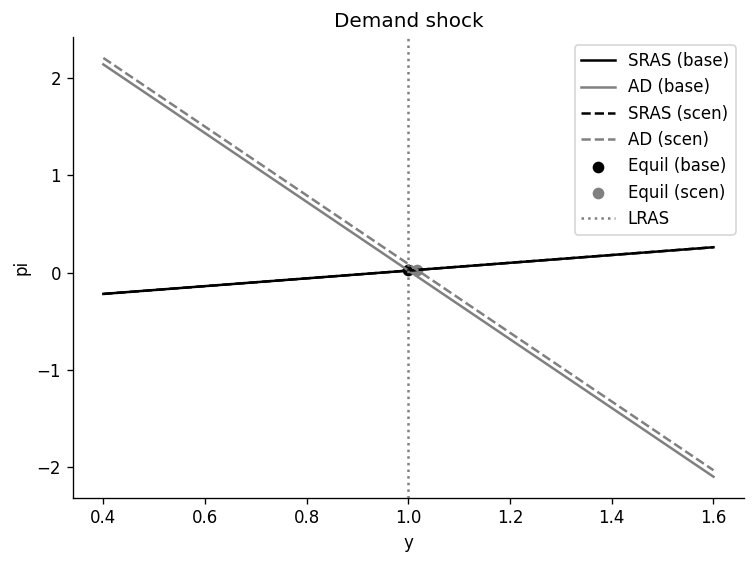

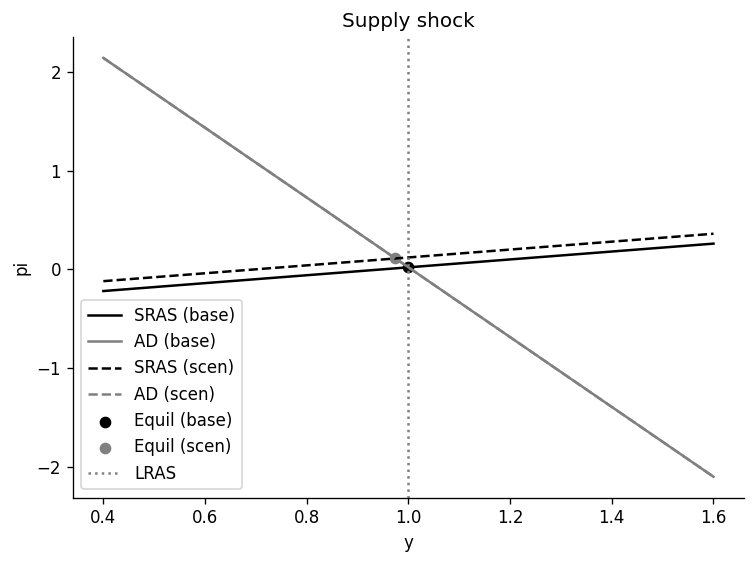

In [11]:
# STARTER: overlay baseline and one shock scenario in the closed economy

def plot_overlay_closed(par, v, s, title, pad=0.6, n=400):
    # baseline case: v = 0, s = 0
    y_base, pi_base, y_grid, pi_ad_base, pi_sras_base = solve_grid(pi_e=par["pi_star"], v=0.0, s=0.0, p=par, pad=pad, n=n)

    # shock scenario: v, s
    y_scen, pi_scen, _, pi_ad_scen, pi_sras_scen = solve_grid(pi_e=par["pi_star"], v=v, s=s, p=par, pad=pad, n=n) # Use the same y_grid as baseline, hence _ for y_grid

    fig, ax = plt.subplots()
    ax.plot(y_grid, pi_sras_base, linestyle='-', label="SRAS (base)", color="black")
    ax.plot(y_grid, pi_ad_base,   linestyle='-', label="AD (base)", color="grey")
    ax.plot(y_grid, pi_sras_scen, linestyle='--', label="SRAS (scen)", color="black")
    ax.plot(y_grid, pi_ad_scen,   linestyle='--', label="AD (scen)", color="grey")
    ax.scatter([y_base], [pi_base], label="Equil (base)", color="black")
    ax.scatter([y_scen], [pi_scen], label="Equil (scen)", color="grey")
    ax.axvline(par["ybar"], color='gray', linestyle=':', label="LRAS")
    ax.set_xlabel("y"); ax.set_ylabel("pi"); ax.set_title(title)
    ax.legend(); plt.tight_layout(); plt.show()

# Then test with, for example:
plot_overlay_closed(p, v=0.02, s=0.0, title="Demand shock")
plot_overlay_closed(p, v=0.00, s=0.1, title="Supply shock")


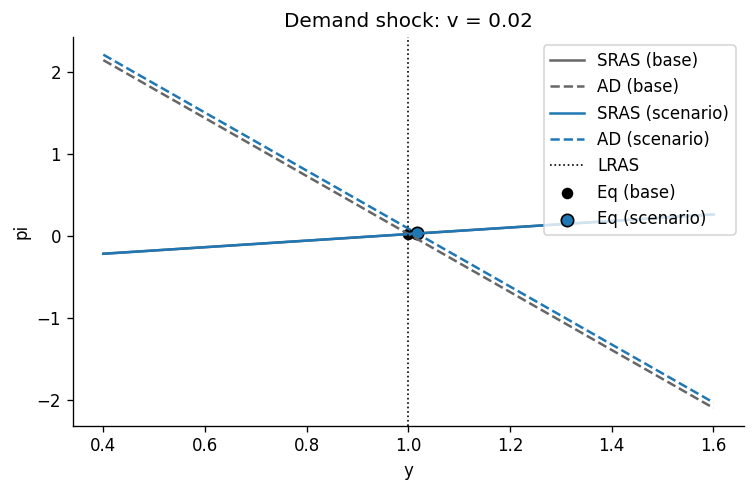

Baseline:  y=0.9985, pi=0.0224
Scenario:  y=1.0165, pi=0.0274


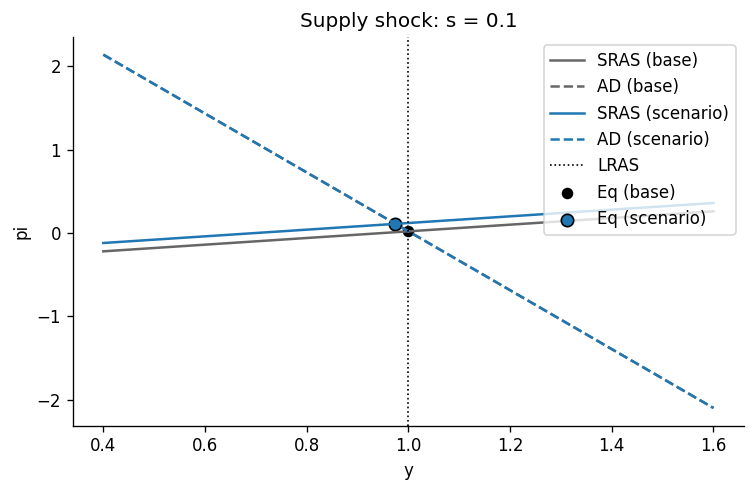

Baseline:  y=0.9985, pi=0.0224
Scenario:  y=0.9744, pi=0.1101


In [12]:
_ = runpy.run_module("A4", run_name="__main__")  # RUNS A3.py

## 5. <a id='toc5_'></a>[Simulation & reproducibility with seeds](#toc0_)

**Goal.** Understand how random **seeds** affect simulations in the AS–AD model:  
same seed → same shocks and paths; different seeds → different realizations.  
You will explore this in three small sub-exercises.

**Sub-exercises.**

- **5.1 Same seed.** Run the **stochastic** simulator twice with the same seed and show that shocks and paths $(v_t, s_t, y_t, \pi_t)$ are exactly identical (numerically and in plots).

- **5.2 Different seeds.** Change the seed and show that the new stochastic run produces different shocks and paths. Visualize the difference in at least one shock series.

- **5.3 Impulse vs stochastic.** With a fixed seed, compare an **impulse** run (one-time demand shock) to a **stochastic** run (many random shocks) and discuss how the dynamics of $y_t$ and $\pi_t$ differ.

**Hints.**

- Use the `seed` argument in `simulate_asad` to control randomness and `np.array_equal` to test exact equality of arrays.  
- Reuse `plot_paths` (or your own plotting code) to illustrate how seeds and experiment types affect the simulated time paths.


In [45]:
# STARTER — run simulate_asad twice with same seed; then change seed
res1 = simulate_asad(T=80, pars=par, mode="stochastic", seed=42)
res2 = simulate_asad(T=80, pars=par, mode="stochastic", seed=42)
assert np.array_equal(res1["v"], res2["v"]) and np.array_equal(res1["s"], res2["s"])
res3 = simulate_asad(T=80, pars=par, mode="stochastic", seed=43)
assert not np.array_equal(res1["v"], res3["v"]) or not np.array_equal(res1["s"], res3["s"])

# TODO: Plot an impulse vs stochastic path (use plot_paths)

# # Using plot paths with different seeds
# plot_paths(res1, title_suffix="Seed 42") # Do it twice if you want
# plot_paths(res3, title_suffix="Seed 43")

# # Using plot paths with impulse instead of stochastic
# stochastic_res = simulate_asad(T=80, pars=par, mode="stochastic", seed=42)
# impulse_res = simulate_asad(T=80, pars=par, mode="impulse", seed=42)
# plot_paths(impulse_res, title_suffix="Impulse Response")
# plot_paths(stochastic_res, title_suffix="Stochastic Path")

### 5.1. <a id='toc5_1_'></a>[Same seed → identical shocks and paths](#toc0_)

**Goal.** Show that using the same random seed in the stochastic AS–AD simulation reproduces exactly the same shock sequences and simulated paths $(v_t, s_t, y_t, \pi_t)$.

**What to do.**
1. Run `simulate_asad` twice with the **same** seed (for example `seed=123`).
2. Check with `np.array_equal` that both draws and paths are identical.
3. Produce a simple plot where the two series lie exactly on top of each other (for example $v_t$ and $y_t$ from both runs).


Same seed → shocks and paths are identical.


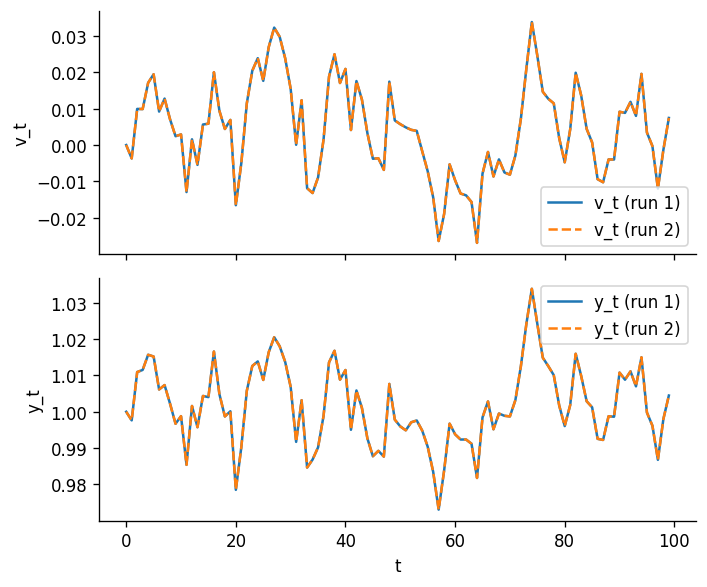

In [52]:
# STARTER 5.1 — same seed, same results

import numpy as np
import matplotlib.pyplot as plt
from functions import par, simulate_asad

# two stochastic runs with the same seed
sto1 = simulate_asad(T=100, pars=par, mode="stochastic", seed=123)
sto2 = simulate_asad(T=100, pars=par, mode="stochastic", seed=123)

sto1["y"], sto2["y"]  # just to show they exist

# 1) check equality of shocks and paths
assert np.array_equal(sto1["y"], sto2["y"])
assert np.array_equal(sto1["pi"], sto2["pi"])
print("Same seed → shocks and paths are identical.")

# 2) plot one shock series and one macro variable from both runs
fig, axes = plt.subplots(2, 1, figsize=(6, 5), sharex=True)
axes[0].plot(sto1["v"], label="v_t (run 1)")
axes[0].plot(sto2["v"], ls="--", label="v_t (run 2)")
axes[0].set_ylabel("v_t"); axes[0].legend()
axes[1].plot(sto1["y"], label="y_t (run 1)")
axes[1].plot(sto2["y"], ls="--", label="y_t (run 2)")
axes[1].set_xlabel("t"); axes[1].set_ylabel("y_t"); axes[1].legend()
plt.tight_layout(); plt.show()


5.1: Same seed → shocks and paths are identical.


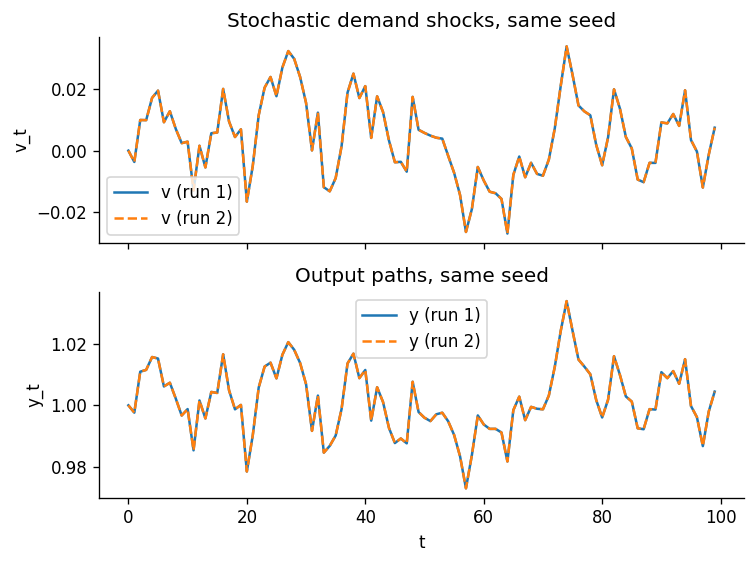

In [15]:
_ = runpy.run_module("A5_1", run_name="__main__")  # RUNS A5_1.py

### 5.2. <a id='toc5_2_'></a>[Different seeds → different shocks](#toc0_)

**Goal.** Show that changing the seed produces a different realization of shocks, and hence different simulated paths.

**What to do.**
1. Reuse one of the runs from 5.1 (for example `seed=123`).
2. Run `simulate_asad` again with a **different** seed (for example `seed=456`).
3. Compare the two shock arrays with `np.array_equal` and show that they differ.
4. Plot the two $v_t$ sequences in one figure to make the difference visible.


Same seed → shocks identical: True
Different seed → shocks identical: False


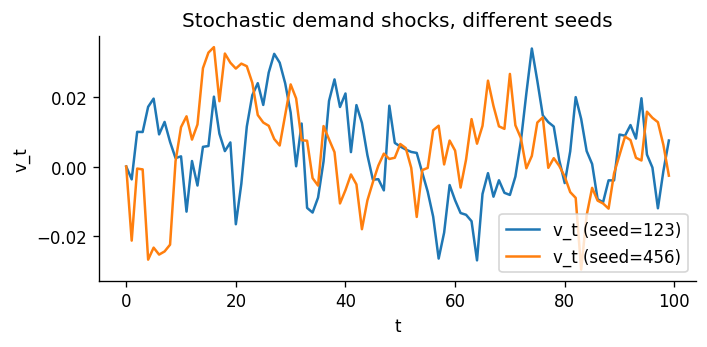

In [55]:
# STARTER 5.2 — different seeds, different shocks

# first stochastic run (reuse or rerun)
sto1 = simulate_asad(T=100, pars=par, mode="stochastic", seed=123)

# second stochastic run with a different seed
sto3 = simulate_asad(T=100, pars=par, mode="stochastic", seed=456)

# 1) check whether shocks are identical or not
same_v = np.array_equal(sto1["v"], sto3["v"])
same_s = np.array_equal(sto1["s"], sto3["s"])
print("Same seed → shocks identical:", True)
print("Different seed → shocks identical:", same_v and same_s)

# 2) plot v_t for both seeds
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(sto1["v"], label="v_t (seed=123)")
ax.plot(sto3["v"], label="v_t (seed=456)")
ax.set_xlabel("t"); ax.set_ylabel("v_t")
ax.set_title("Stochastic demand shocks, different seeds")
ax.legend(); plt.tight_layout(); plt.show()


5.2: Same seed → shocks identical:    True
5.2: Different seed → shocks identical: False


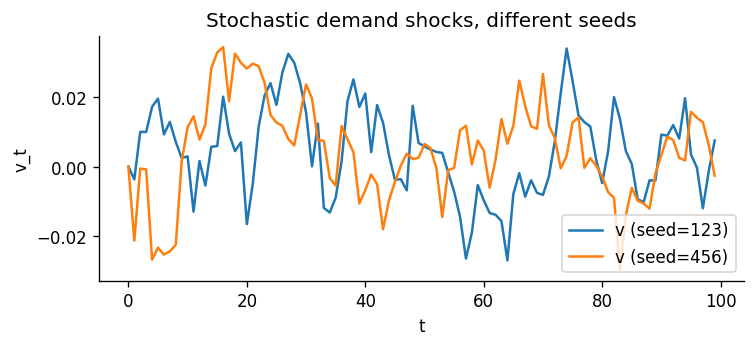

In [17]:
_ = runpy.run_module("A5_2", run_name="__main__")  # RUNS A5_2.py

### 5.3. <a id='toc5_3_'></a>[Impulse vs stochastic runs (same seed, different mode)](#toc0_)

**Goal.** Compare a one–time **impulse** experiment to a fully **stochastic** simulation, using the same seed for reproducibility.

**What to do.**
1. Run an impulse experiment with `mode="impulse"` (for example a demand shock of size $0.02$ at $t=0$).
2. Run a stochastic experiment with `mode="stochastic"` and the **same** seed.
3. Use `plot_paths` (or your own plots) to visualize the very different dynamics of $y_t$ and $\pi_t$ in the impulse vs stochastic case.


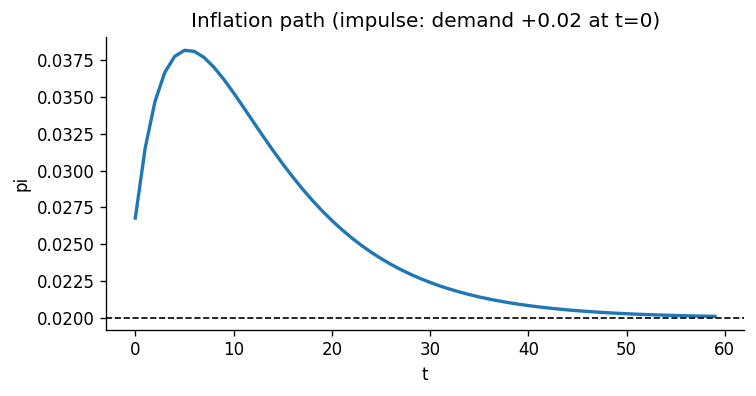

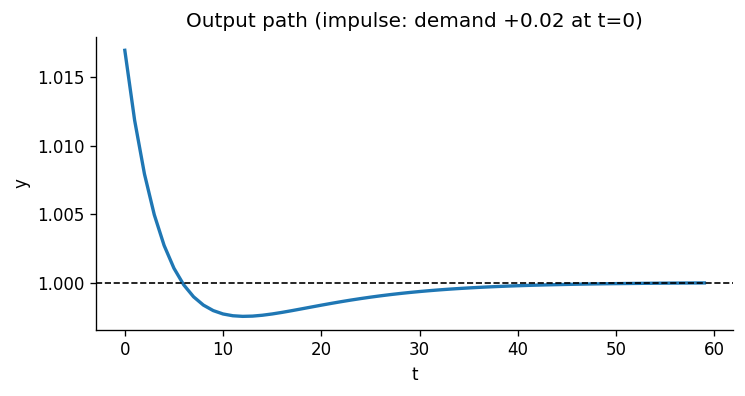

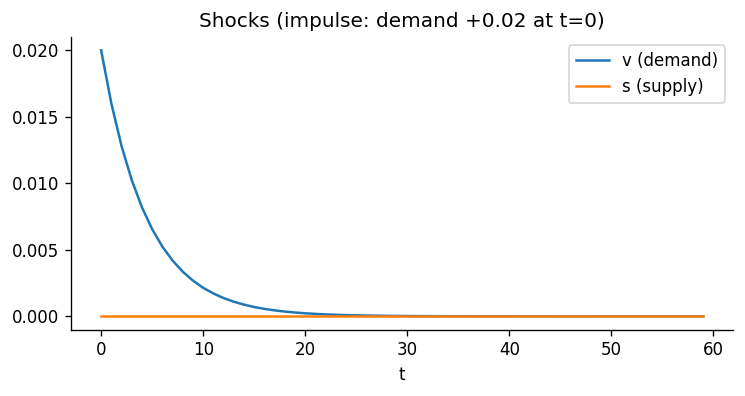

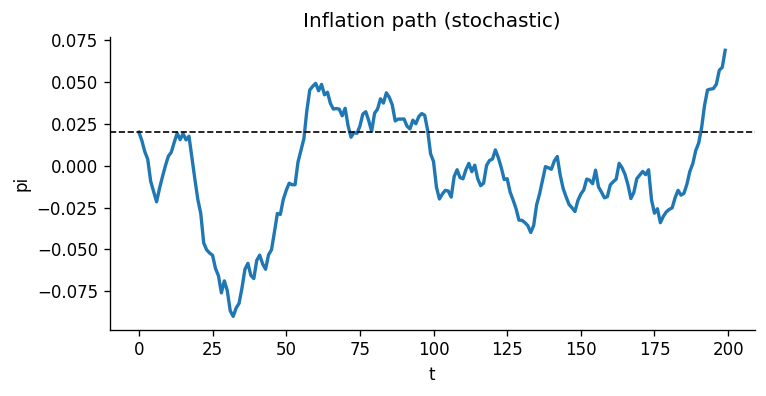

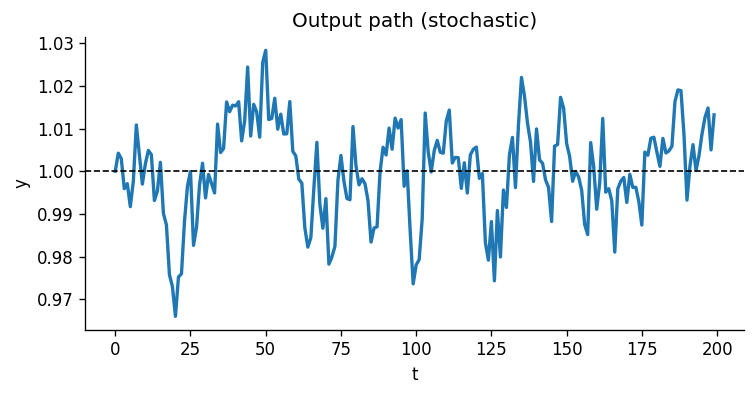

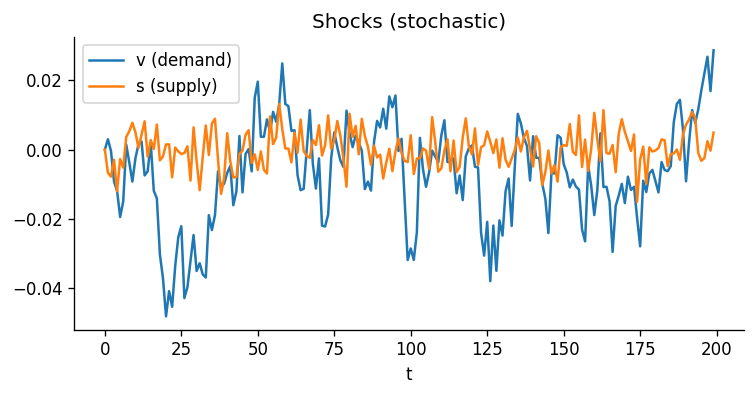

In [56]:
# STARTER 5.3 — impulse vs stochastic

from functions import plot_paths

# impulse run: single demand shock at t = 0
imp_d = simulate_asad(
    T=60,
    pars=par,
    mode="impulse",
    which="demand",
    size=0.02,
    seed=7,
)

# stochastic run: many random shocks
sto = simulate_asad(
    T=200,
    pars=par,
    mode="stochastic",
    seed=7,
)

# plot both experiments
plot_paths(imp_d, title_suffix="(impulse: demand +0.02 at t=0)")
plot_paths(sto,   title_suffix="(stochastic)")

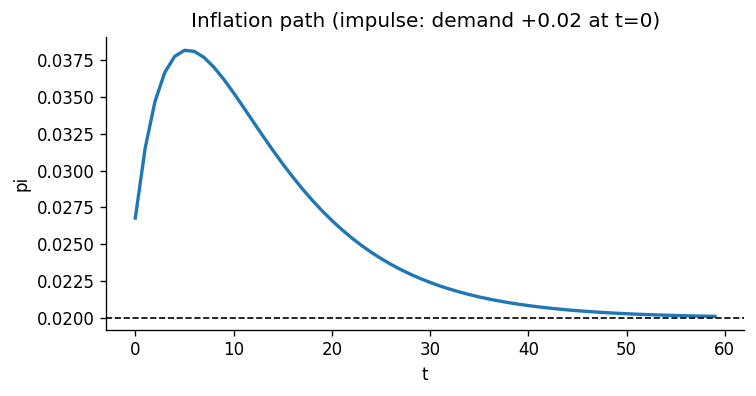

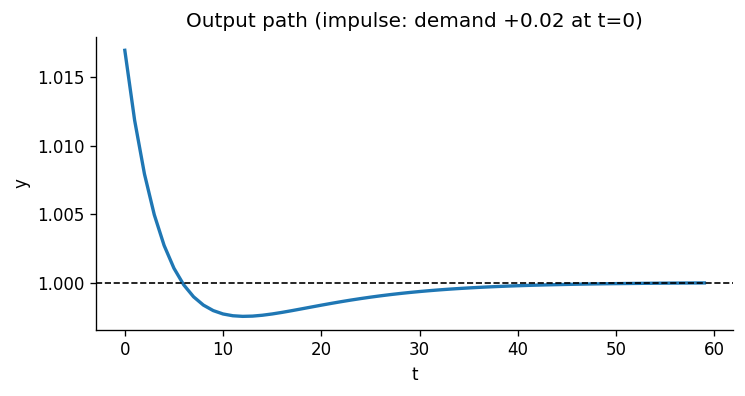

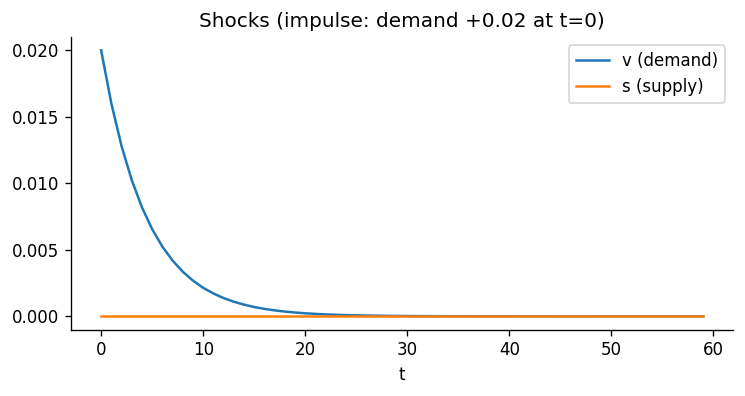

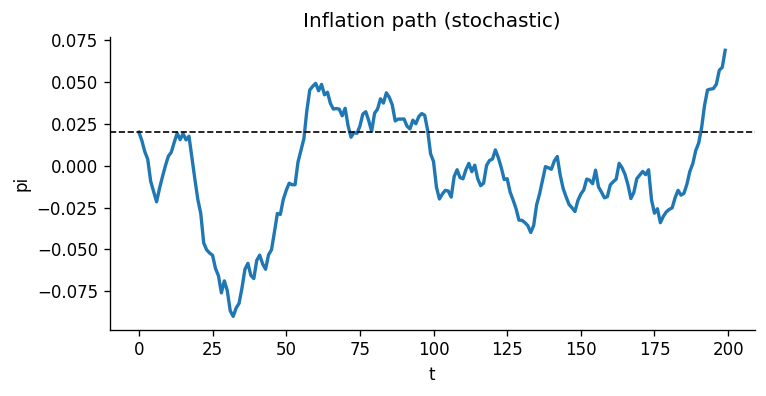

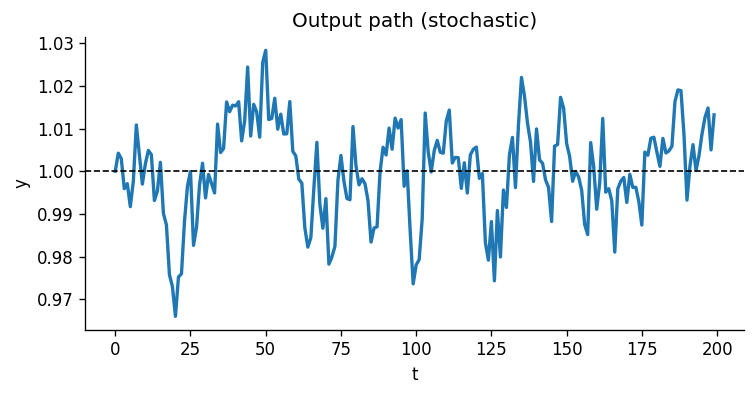

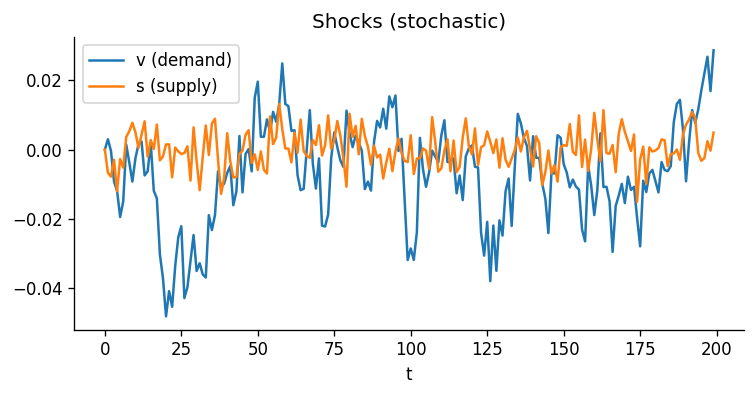

5.3: Plotted impulse vs stochastic simulations for comparison.


In [19]:
_ = runpy.run_module("A5_3", run_name="__main__")  # RUNS A5_3.py

## 6. <a id='toc6_'></a>[Tiny policy search over $(a_1,a_2)$](#toc0_)

**Goal.** See how the Taylor rule coefficients $(a_1,a_2)$ affect stability by choosing them to minimize a quadratic loss in a simulated sample.

**Loss function.**  
For each pair $(a_1,a_2)$, define
$$
\mathcal L(a_1,a_2)
= \sum_{t=0}^{T-1} \bigl(\pi_t - \pi^*\bigr)^2
+ \lambda \bigl(y_t - \bar y\bigr)^2,
$$
where $\lambda \ge 0$ controls how much weight you put on output gaps relative to inflation gaps.

**Steps.**

1. **Fix shocks and sample length.**  
   Choose a horizon $T$ and a seed. Generate one sequence of shocks $(v_t,s_t)$ (for example AR(1) processes) and keep it fixed for the whole policy search.

2. **Grid over policy coefficients.**  
   Build coarse grids for $a_1$ and $a_2$ (for example a few values around the baseline). For each pair $(a_1,a_2)$:
   - update `par["a1"]` and `par["a2"]`,
   - simulate the model with the same shock sequence,
   - compute the loss $\mathcal L(a_1,a_2)$.

3. **Pick and visualize the best policy.**  
   Store all losses in a 2D array, find the grid point with the smallest loss, and report the corresponding $(a_1^*,a_2^*)$.  
   Plot a heatmap of $\mathcal L(a_1,a_2)$ over the grid and mark the minimum.


### 6.1. <a id='toc6_1_'></a>[Build AR(1) shocks for demand and supply](#toc0_)

**Goal.** Create a helper that generates dynamic shocks $(v_t, s_t)$ using simple AR(1) processes, which you will reuse for all Taylor rule experiments.

We want
$$
v_t = \delta v_{t-1} + x_t, \quad s_t = \omega s_{t-1} + c_t,
$$
where $x_t$ and $c_t$ are i.i.d. normal shocks with standard deviations $\sigma_x$ and $\sigma_c$ taken from the parameter dictionary.

**Tasks.**

1. Write a function `make_shocks_ps(T, p, seed)` that  
   - sets up a random generator with the provided `seed`,  
   - draws $x_t$ and $c_t$,  
   - fills two arrays `v` and `s` using the AR(1) formulas.  
2. Return `v, s`. Optionally, plot them to see how persistent they are.


In [57]:
# STARTER 6.1 — AR(1) shocks for v_t and s_t

import numpy as np

def make_shocks_ps(T, p, seed=0):
    """
    Build AR(1) processes for demand shocks v_t and supply shocks s_t.

    v_t = delta * v_{t-1} + x_t
    s_t = omega * s_{t-1} + c_t
    """
    rng = np.random.default_rng(seed)

    x = rng.normal(loc=0.0, scale=p["sigma_x"], size=T)
    c = rng.normal(loc=0.0, scale=p["sigma_c"], size=T)

    v = np.zeros(T)
    s = np.zeros(T)

    for t in range(1, T):
        v[t] = p["delta"] * v[t-1] + x[t]
        s[t] = p["omega"] * s[t-1] + c[t]

    return v, s

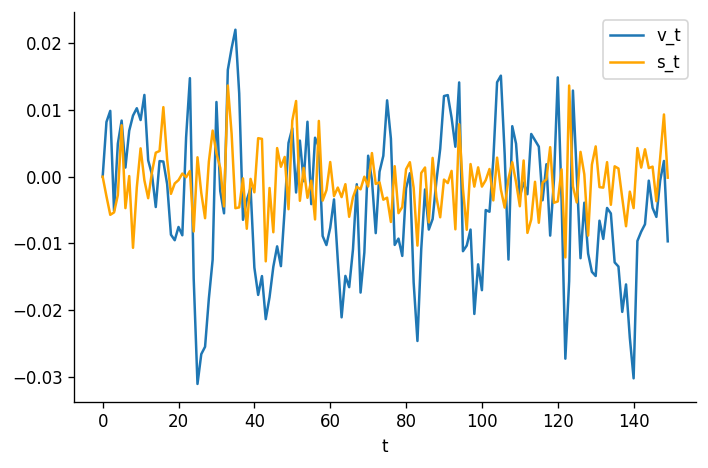

In [77]:
# dynamic parameter dict for the policy search
p_dyn = {
    **par,           # copy all baseline parameters
    "delta":   0.80, # persistence of demand shock v_t
    "omega":   0.15, # persistence of supply shock s_t
    "sigma_x": 0.01, # std dev of v_t innovation
    "sigma_c": 0.005 # std dev of s_t innovation
}

# Plot example shocks
v, s = make_shocks_ps(T=150, p=p_dyn, seed=1)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharex=True)
ax.plot(v, label="v_t")
ax.plot(s, label="s_t", color="orange")
ax.set_xlabel("t"); ax.legend(loc="upper right")
plt.tight_layout(); plt.show()

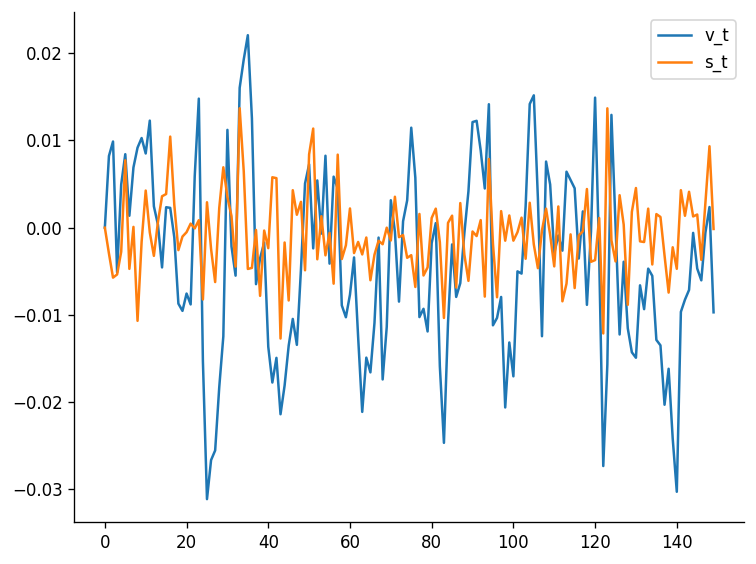

In [22]:
_ = runpy.run_module("A6_1", run_name="__main__")  # RUNS A6_1.py

### 6.2. <a id='toc6_2_'></a>[Simulate with a given rule and compute quadratic loss](#toc0_)

**Goal.** Given Taylor rule coefficients $(a_1, a_2)$ and fixed shock paths $(v_t, s_t)$, simulate the dynamic AS AD model and compute the quadratic loss
$$
\mathcal L = \sum_t (\pi_t - \pi^*)^2 + \lambda (y_t - \bar y)^2.
$$

**Tasks.**

1. Implement `simulate_with_rule_ps(a1, a2, v, s, p)` that  
   - copies the parameter dictionary `p` and overwrites `a1` and `a2`,  
   - iterates over $t$ and at each step calls `solve_grid` with current $(v_t, s_t)$ and previous expected inflation $\pi_e$,  
   - collects arrays `y` and `pi`.  
2. Implement `loss_quad_ps(y, pi, p, lam)` that returns the scalar loss for one simulation.


In [78]:
# STARTER 6.2 — simulate for (a1, a2) and compute loss

from functions import solve_grid

def simulate_with_rule_ps(a1, a2, v, s, p, pad=0.6, n=400):
    """
    Simulate the dynamic AS AD system for given Taylor rule coefficients (a1, a2)
    and given shock paths v_t, s_t.
    """
    P = {**p, "a1": float(a1), "a2": float(a2)}
    
    T = len(v)
    y  = np.empty(T)
    pi = np.empty(T)
    
    pi_prev = P["pi_star"]
    for t in range(T):
        y[t], pi[t], *_ = solve_grid(
            pi_e = pi_prev,
            v    = v[t],
            s    = s[t],
            p    = P,
            pad  = pad,
            n    = n,
        )
        pi_prev = pi[t]
    
    return y, pi


def loss_quad_ps(y, pi, p, lam=0.5):
    """
    L = sum_t (pi_t - pi_star)^2 + lam * (y_t - ybar)^2
    """
    term_pi = (pi - p["pi_star"])**2
    term_y  = (y  - p["ybar"])**2
    return float(np.sum(term_pi + lam * term_y))


In [79]:
_ = runpy.run_module("A6_2", run_name="__main__")  # RUNS A6_1.py

### 6.3. <a id='toc6_3_'></a>[Tiny grid search over $(a_1, a_2)$ and heatmap](#toc0_)

**Goal.** Use your shocks and loss function to search over a coarse grid of Taylor rule parameters and visualize which pair performs best.

**Tasks.**

1. Fix $T$, $\lambda$, and a seed. Use `make_shocks_ps` once to get $(v_t, s_t)$ and keep them fixed.  
2. Build arrays `a1_vals` and `a2_vals` with a small number of grid points.  
3. For each pair $(a_1, a_2)$, run `simulate_with_rule_ps`, compute the loss with `loss_quad_ps`, and store it in a 2D loss matrix `L`.  
4. Find the minimum in `L`, report the corresponding $(a_1, a_2)$, and plot a heatmap of `L` over the grid (mark the minimum).


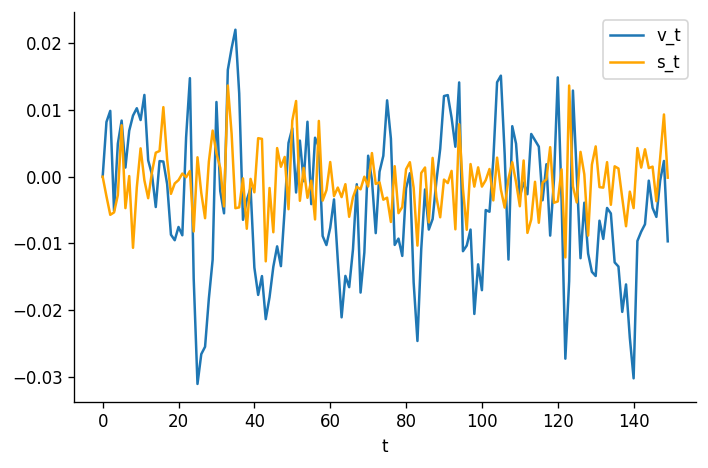

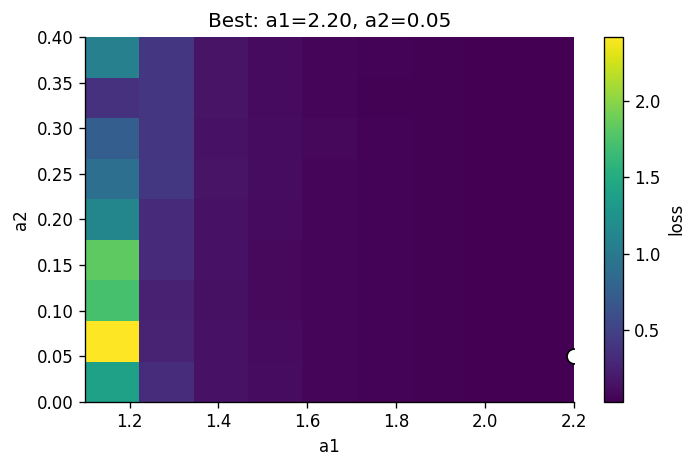

{'a1': 2.2, 'a2': 0.05, 'loss': 0.02902292984444269}


In [80]:
# STARTER 6.3 — grid search over (a1, a2) and heatmap

import matplotlib.pyplot as plt

def tiny_grid_search_ps(p, a1_vals, a2_vals, T=150, lam=0.5, seed=1, pad=0.6, n=400):
    """
    For each (a1, a2) on a coarse grid, simulate the model with fixed shocks
    and compute the quadratic loss. Return the loss matrix and the best pair.
    """
    v, s = make_shocks_ps(T, p, seed=seed)
    L = np.empty((len(a1_vals), len(a2_vals)))
    
    for i, a1 in enumerate(a1_vals):
        for j, a2 in enumerate(a2_vals):
            y, pi = simulate_with_rule_ps(a1, a2, v, s, p, pad=pad, n=n)
            L[i, j] = loss_quad_ps(y, pi, p, lam)
    
    i0, j0 = np.unravel_index(np.argmin(L), L.shape)
    best = {
        "a1": float(a1_vals[i0]),
        "a2": float(a2_vals[j0]),
        "loss": float(L[i0, j0]),
    }
    
    # Plot of s and v
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(v, label="v_t")
    ax.plot(s, label="s_t", color="orange")
    ax.set_xlabel("t"); ax.legend(loc="upper right")
    plt.tight_layout(); plt.show()
    
    # heatmap of L over (a1, a2)
    plt.figure(figsize=(6, 4))
    plt.imshow(
        L.T,
        origin="lower",
        aspect="auto",
        extent=[a1_vals[0], a1_vals[-1], a2_vals[0], a2_vals[-1]],
    )
    plt.colorbar(label="loss")
    plt.scatter(best["a1"], best["a2"], c="w", edgecolor="k", s=80)
    plt.xlabel("a1")
    plt.ylabel("a2")
    plt.title(f"Best: a1={best['a1']:.2f}, a2={best['a2']:.2f}")
    plt.tight_layout()
    plt.show()
    
    return L, best

# Example grids you can try after implementing:
p_dyn   = {**par, "delta":0.80, "omega":0.15, "sigma_x":0.01, "sigma_c":0.005}
a1_vals = np.linspace(1.1, 2.2, 9)
a2_vals = np.linspace(0.00, 0.40, 9)
L, best = tiny_grid_search_ps(p_dyn, a1_vals, a2_vals, T=150, lam=0.5, seed=1)
print(best)


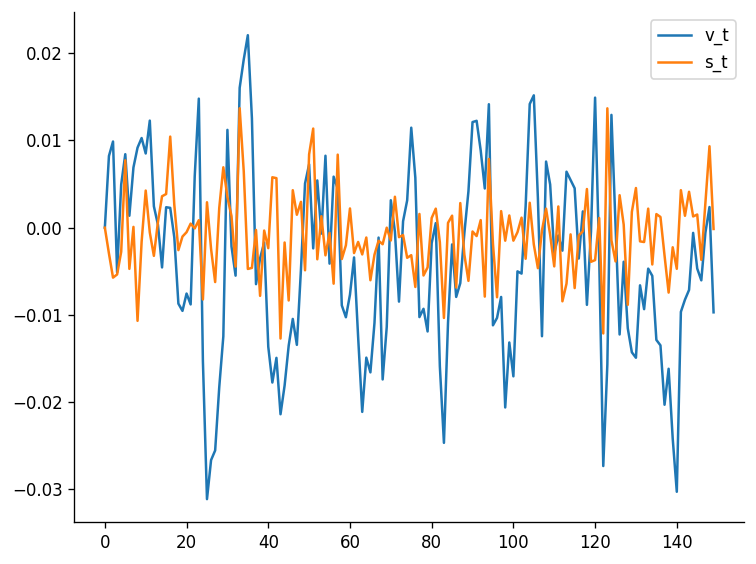

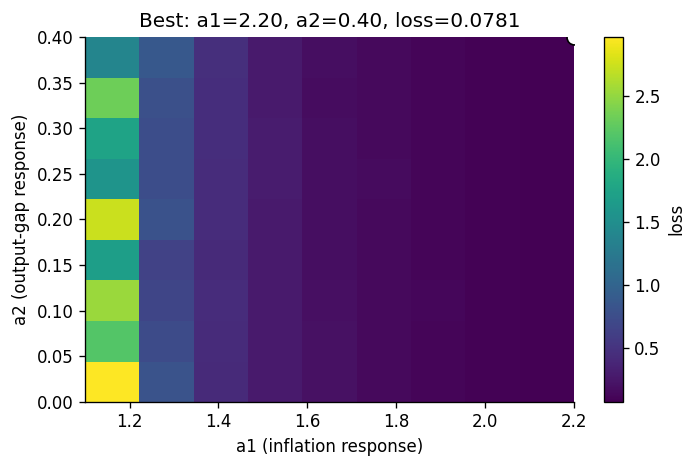

{'a1': 2.2, 'a2': 0.4, 'loss': 0.07805205104439775}


In [26]:
_ = runpy.run_module("A6_3", run_name="__main__")  # RUNS A6_3.py

## 7. <a id='toc7_'></a>[Open economy: fixed vs flexible (static)](#toc0_)

**Goal.** Compare static equilibria under **fixed** vs **flexible** exchange-rate regimes.

**Steps.**
1. Use `plot_static_open(pi_e, v, s, p=par_open, pad=0.6)` for both regimes (helper solves per regime).
2. Try a demand shock \(v=+0.02\) and a supply shock \(s=+0.01\).

**Hints.**
- If `pi_e=None`, the helper chooses a regime-appropriate anchor.


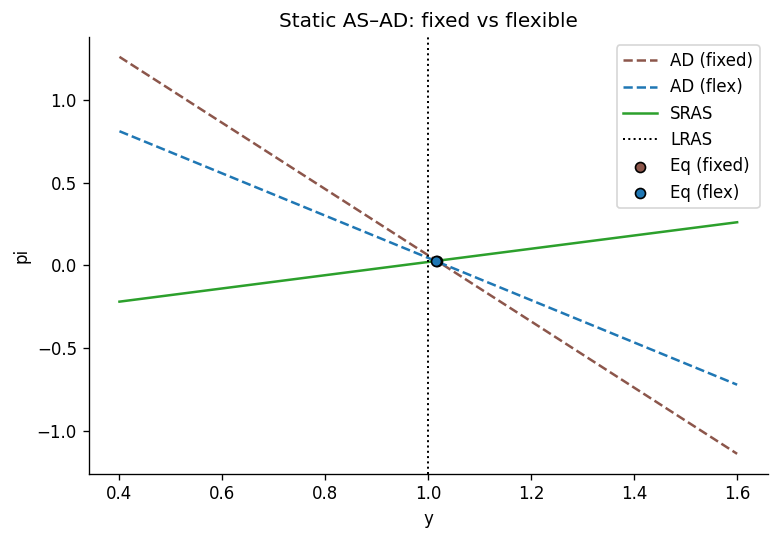

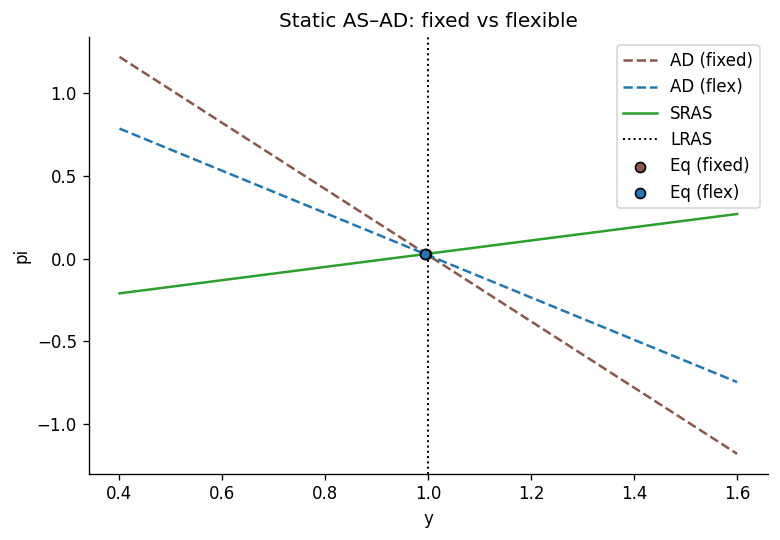

In [82]:
# STARTER — call the helper with two shock configurations
plot_static_open(pi_e=par["pi_star"], v=0.02, s=0.00, p=par, pad=0.6)
plot_static_open(pi_e=par["pi_star"], v=0.00, s=0.01, p=par, pad=0.6)


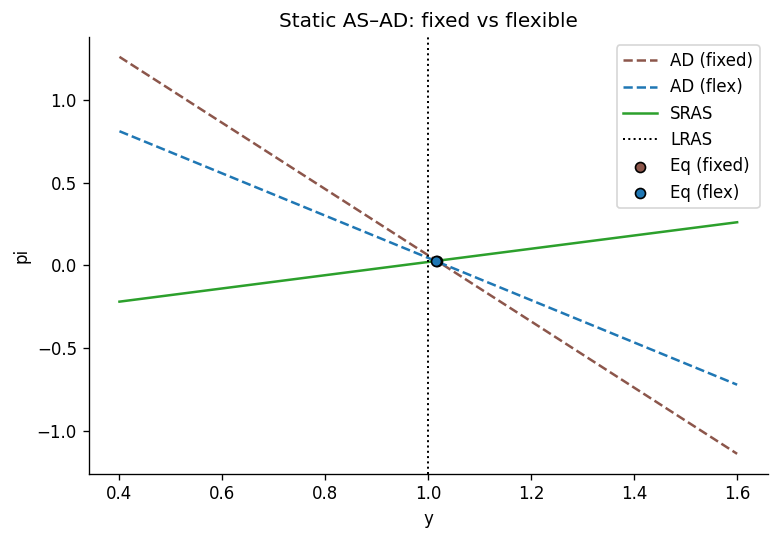

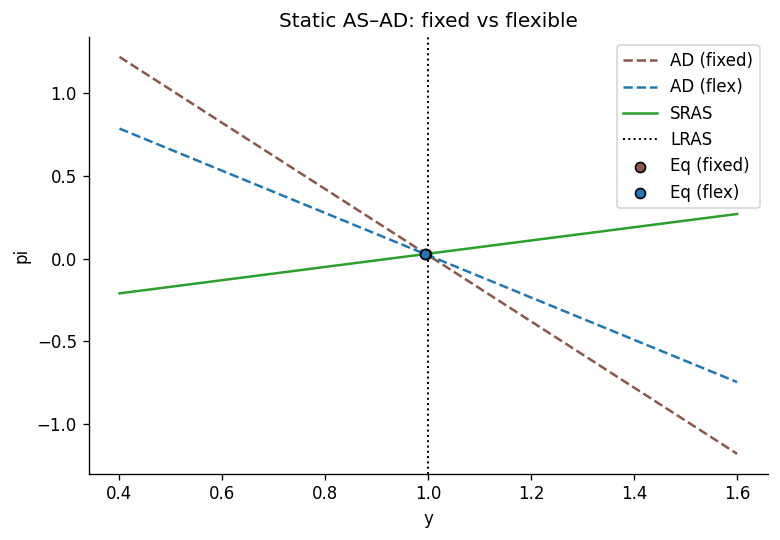

In [28]:
_ = runpy.run_module("A7", run_name="__main__")  # RUNS A7.py

## 8. <a id='toc8_'></a>[Optional: Peg vs float under persistent cost pressure](#toc0_)

**Goal.** Compare how **fixed** and **flexible** exchange rate regimes handle **persistent supply shocks** in the open economy AS AD model.

You will work with the existing simulator `simulate_open` and:

- construct a **supply dominated** stochastic scenario,
- compare **volatility** of output and inflation under a peg vs a float,
- visualize and interpret the trade off between the two regimes.


### 8.1. <a id='toc8_1_'></a>[Set up a supply dominated stochastic scenario](#toc0_)

**Goal.** Create a variant of the parameter dictionary where **supply shocks dominate** and simulate long stochastic samples under a fixed and a flexible exchange rate regime.

**What to do.**

1. Build a new parameter dictionary, for example `par_supply`, starting from `par` and making supply shocks more important than demand shocks (for instance, reduce $ \sigma_x $ and increase $ \sigma_c $).
2. Choose a horizon $T$ (for example $T=200$) and a seed.
3. Run two stochastic simulations with the **same** parameters and **same** seed:
   - one with `regime="fixed"`,
   - one with `regime="flex"`.
4. Store the results in `res_fix_sto` and `res_flex_sto` for later use.


In [29]:
# STARTER 8.1 — supply dominated stochastic simulations (fixed vs flex)

# import numpy as np
#
# # 1) Start from the baseline parameters and tilt toward supply shocks
# # par_supply = {**par,
# #               "sigma_x": ...,   # smaller demand innovation
# #               "sigma_c": ...}   # larger supply innovation
#
# # 2) Choose horizon and seed
# # T = ...
# # seed = ...
#
# # 3) Stochastic simulations under fixed and flexible regimes
# # res_fix_sto  = simulate_open(T=T, p=par_supply,
# #                              mode="stochastic", regime="fixed", seed=seed)
# # res_flex_sto = simulate_open(T=T, p=par_supply,
# #                              mode="stochastic", regime="flex",  seed=seed)


In [30]:
_ = runpy.run_module("A8_1", run_name="__main__")  # RUNS A8_1.py

### 8.2. <a id='toc8_2_'></a>[Compare volatility of output and inflation](#toc0_)

**Goal.** Quantify how much $y_t$ and $\pi_t$ fluctuate under each regime when supply shocks dominate.

**What to do.**

1. Take the two results `res_fix_sto` and `res_flex_sto` from 6.1.
2. Optionally discard an initial burn in period (for example the first 20 observations) to focus on the stationary part of the simulation.
3. Compute the sample standard deviations:
   - $ \operatorname{std}(\pi_t - \pi^*) $ for each regime,
   - $ \operatorname{std}(y_t - \bar y) $ for each regime.
4. Print the four numbers in a compact summary so you can see which regime stabilizes inflation more and which one stabilizes output more.


In [31]:
# STARTER 6.2 — compute volatility under fixed vs flex

# # convenience: steady state values
# # pi_star = par_supply["pi_star"]
# # ybar    = par_supply["ybar"]
#
# # # optional burn in
# # burn = 20
# # sl = slice(burn, None)
#
# # # extract series after burn in
# # y_fix   = res_fix_sto["y"][sl]
# # y_flex  = res_flex_sto["y"][sl]
# # pi_fix  = res_fix_sto["pi"][sl]
# # pi_flex = res_flex_sto["pi"][sl]
#
# # # compute standard deviations of gaps
# # std_y_fix   = np.std(y_fix  - ybar)
# # std_y_flex  = np.std(y_flex - ybar)
# # std_pi_fix  = np.std(pi_fix  - pi_star)
# # std_pi_flex = np.std(pi_flex - pi_star)
#
# # print("Std dev output gap:   fixed =", std_y_fix,  ", flex =", std_y_flex)
# # print("Std dev inflation gap: fixed =", std_pi_fix, ", flex =", std_pi_flex)


In [32]:
_ = runpy.run_module("A8_2", run_name="__main__")  # RUNS A8_2.py

Volatility measures (after burn-in):
  Std dev output gap:    fixed = 0.0161, flex = 0.0197
  Std dev inflation gap: fixed = 0.0323, flex = 0.0253


### 8.3. <a id='toc8_3_'></a>[Plot and interpret the stochastic paths](#toc0_)

**Goal.** Visualize how $y_t$ and $\pi_t$ evolve under each regime when hit by the same sequence of supply dominated shocks and relate this to the volatility measures from 6.2.

**What to do.**

1. Use `plot_irfs_compare(res_fix_sto, res_flex_sto, title_suffix="(stochastic, supply dominated)")` or create your own plots with $t$ on the horizontal axis and separate panels for inflation and output.
2. Make sure both regimes are shown in the same figure for each variable (fixed vs flex).
3. Briefly summarize what you see:
   - Which regime delivers **more stable inflation**?
   - Which regime delivers **more stable output**?
   - How does this match your standard deviation results from 8.2?


In [33]:
# STARTER 8.3 — plot and discuss

# # Option A: reuse the helper
# # plot_irfs_compare(res_fix_sto, res_flex_sto,
# #                   title_suffix="(stochastic, supply dominated)")
#
# # Option B: write your own quick plots
# # T = len(res_fix_sto["y"])
# # t = np.arange(T)
# #
# # fig, axes = plt.subplots(2, 1, figsize=(6.4, 4.8), sharex=True)
# #
# # axes[0].plot(t, res_fix_sto["pi"],  label="fixed")
# # axes[0].plot(t, res_flex_sto["pi"], label="flex")
# # axes[0].axhline(par_supply["pi_star"], ls="--", c="k", lw=1)
# # axes[0].set_ylabel("pi_t"); axes[0].set_title("Inflation paths")
# # axes[0].legend()
# #
# # axes[1].plot(t, res_fix_sto["y"],  label="fixed")
# # axes[1].plot(t, res_flex_sto["y"], label="flex")
# # axes[1].axhline(par_supply["ybar"], ls="--", c="k", lw=1)
# # axes[1].set_xlabel("t"); axes[1].set_ylabel("y_t")
# # axes[1].set_title("Output paths"); axes[1].legend()
# #
# # plt.tight_layout(); plt.show()


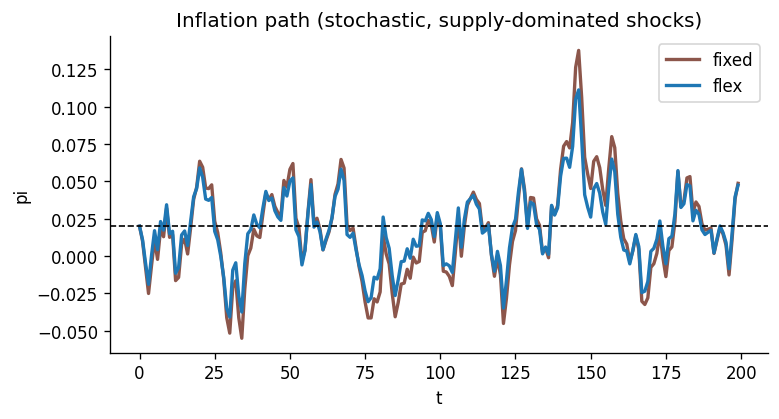

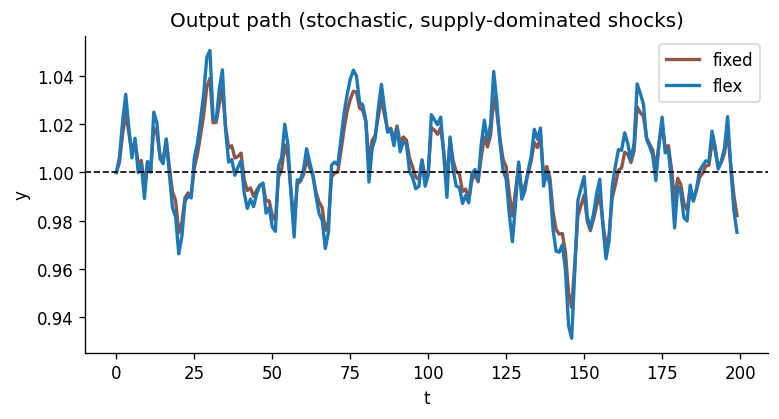

In [34]:
_ = runpy.run_module("A8_3", run_name="__main__")  # RUNS A8_3.py